In [54]:
from io import open
import glob
import os
import unicodedata
import string

# Classifying names with a character level RNN

## Preparing the data

You can download the data from [here](https://download.pytorch.org/tutorial/data.zip).

In [55]:
def findFiles(path): return glob.glob(path)

In [62]:
print(findFiles('/Users/marissaposner/Downloads/data/names/*.txt'))

['/Users/marissaposner/Downloads/data/names/Czech.txt', '/Users/marissaposner/Downloads/data/names/German.txt', '/Users/marissaposner/Downloads/data/names/Arabic.txt', '/Users/marissaposner/Downloads/data/names/Japanese.txt', '/Users/marissaposner/Downloads/data/names/Chinese.txt', '/Users/marissaposner/Downloads/data/names/Vietnamese.txt', '/Users/marissaposner/Downloads/data/names/Russian.txt', '/Users/marissaposner/Downloads/data/names/French.txt', '/Users/marissaposner/Downloads/data/names/Irish.txt', '/Users/marissaposner/Downloads/data/names/English.txt', '/Users/marissaposner/Downloads/data/names/Spanish.txt', '/Users/marissaposner/Downloads/data/names/Greek.txt', '/Users/marissaposner/Downloads/data/names/Italian.txt', '/Users/marissaposner/Downloads/data/names/Portuguese.txt', '/Users/marissaposner/Downloads/data/names/Scottish.txt', '/Users/marissaposner/Downloads/data/names/Dutch.txt', '/Users/marissaposner/Downloads/data/names/Korean.txt', '/Users/marissaposner/Downloads/da

In [63]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [64]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [65]:
print(unicodeToAscii('Ślusàrski')) #take unicode and make it ascii characters

Slusarski


In [66]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

In [69]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/Users/marissaposner/Downloads/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [70]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turning names into Tensors

We use one-hot representation for each letter. Thus, the size of the vector will be $1\times n$ where $n$ is the number of letters. One hot encoding is usefull when dealing with categorical data when feeding it to a machine learning algorithm. The one-hot vector is filled with 0s except for a 1 at the index of the current letter. For example: `'b' = [0, 1, 0, 0, ...]`.

A word of length $m$ will be a 2D matrix of size $m\times n$.

`'abba' = [[1, 0, 0, ...], 
           [0, 1, 0, ...], 
           [0, 1, 0, ...], 
           [1, 0, 0, ...],]
           `

PyTorch assumes **everything** is in batches so we need to add an additional dimension as follows for any word: $m\times batch \times n$ in order to feed it into a PyTorch neural network.

In [71]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## A simple RNN

![rnn](images/rnn.png)

In [72]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) #concatenate input and hidden space
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [73]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by pre-computing batches of Tensors.

In [74]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9476, -2.8457, -2.9118, -2.9665, -2.8507, -2.9957, -2.9169, -2.9042,
         -2.8296, -2.9883, -2.8721, -2.8560, -2.9441, -2.8388, -2.8994, -2.8339,
         -2.7609, -2.8970]], grad_fn=<LogSoftmaxBackward>)


In [75]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Korean', 16)


In [76]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Czech / line = Fremut
category = Arabic / line = Morcos
category = Russian / line = Otstavnoi
category = Vietnamese / line = Dang
category = Arabic / line = Kassab
category = Dutch / line = Roijacker
category = Chinese / line = Min
category = Arabic / line = Shalhoub
category = Polish / line = Kumiega
category = Korean / line = Youj


In [77]:
criterion = nn.NLLLoss()

In [78]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [79]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.2671 Africani / Polish ✗ (Italian)
10000 10% (0m 12s) 1.2962 Zhu / Vietnamese ✗ (Chinese)
15000 15% (0m 18s) 3.0085 Shibaguchi / Italian ✗ (Japanese)
20000 20% (0m 24s) 1.2580 Neroni / Italian ✓
25000 25% (0m 30s) 1.5605 Kang / Chinese ✗ (Korean)
30000 30% (0m 35s) 1.3152 Harb / Arabic ✓
35000 35% (0m 41s) 1.4256 Yeo / Chinese ✗ (Korean)
40000 40% (0m 47s) 2.3269 Papadelias / Scottish ✗ (Greek)
45000 45% (0m 52s) 0.0806 Timakov / Russian ✓
50000 50% (0m 59s) 0.6044 Dioli / Italian ✓
55000 55% (1m 5s) 0.4346 Ronchi / Italian ✓
60000 60% (1m 12s) 0.7315 Rothbauer / German ✓
65000 65% (1m 18s) 1.6416 Fabron / French ✓
70000 70% (1m 25s) 1.1451 Juan / Chinese ✓
75000 75% (1m 30s) 2.7717 Broz / Korean ✗ (Polish)
80000 80% (1m 36s) 2.5263 Thomson / Russian ✗ (Scottish)
85000 85% (1m 42s) 0.0321 Papadelias / Greek ✓
90000 90% (1m 48s) 0.9916 Flowers / English ✓
95000 95% (1m 54s) 0.0301 Shibaguchi / Japanese ✓
100000 100% (1m 59s) 0.8860 Garcia / Spanish ✓


In [80]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

<Figure size 640x480 with 1 Axes>

## Evaluation

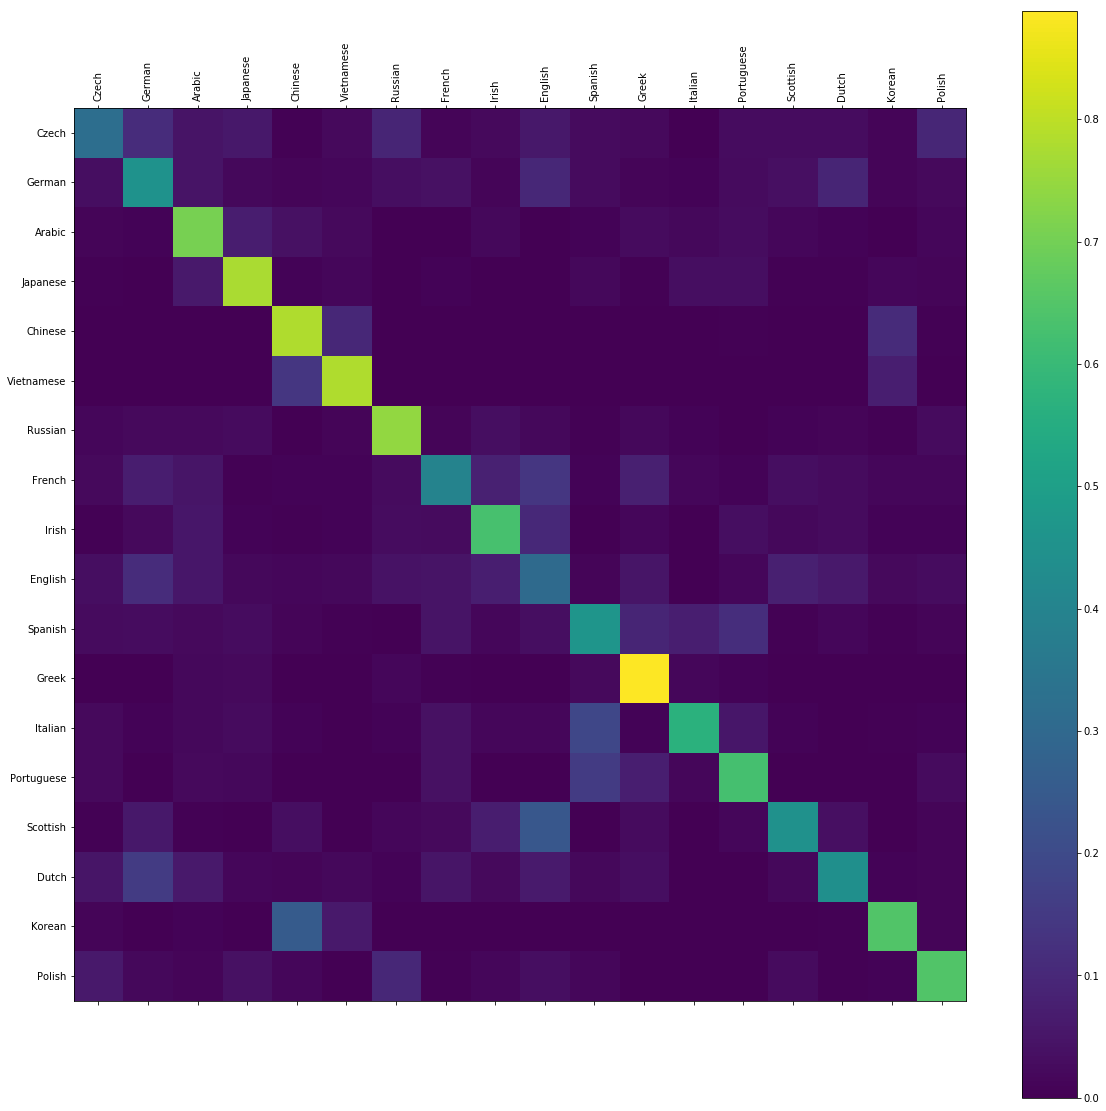

In [81]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)  #which mistakes i made and which languages are most prone to mistakes
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [82]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.63) Russian
(-1.04) Czech
(-2.81) Polish

> Jackson
(-1.42) Russian
(-1.44) Scottish
(-1.50) English

> Satoshi
(-1.06) Polish
(-1.51) Japanese
(-1.60) Arabic
